In [15]:
from google.colab import drive
drive.mount('./content')
import os
import random
import datetime
import re
import math
import logging
from collections import OrderedDict
import multiprocessing
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM
from keras.engine.topology import Layer, InputSpec
import glob

Drive already mounted at ./content; to attempt to forcibly remount, call drive.mount("./content", force_remount=True).


In [7]:
path = r'/content/content/My Drive/Avanti/dataset_4(UnzippedFil es)/dataset_4'

In [8]:

'''
Input pipeline for the model, Image data generator and using the flow from the 
directory with categorical class modes .
'''

image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    
    fill_mode="nearest",
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,          
    
)

img_generator = image_data_generator.flow_from_directory(
    path,
    target_size=(512,512),
    batch_size=6,
    shuffle=True,
    seed=None,
    color_mode="rgb",
    class_mode = 'categorical',
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset=None,
    interpolation="nearest",
)



Found 7200 images belonging to 12 classes.


In [18]:
classes_list = img_generator.class_indices
classes_list = list(classes_list.keys())

In [ ]:
class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.

    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when making inferences
        """
        return super(self.__class__, self).call(inputs, training=training)


def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])


############################################################
#  Resnet Graph
############################################################

# Code adopted from:
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x



def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x

def resnet_graph(input_image_shape, num_classes, train_bn=True):
    """Build a ResNet graph.
      Input :
        input_image_shape - Shape of the input images for the model 
        num_classes - number of classes considered for the classifier model 
        train_bn - Apply batch normalization in the resnet the architecture 
    Output :
        Return a numpy array of the classification calsses of the images 

    """
    
    '''
    # Stage 0 - 512 * 512 * 3
        Taking the input image and applying the padding to preserve the 
    features of the edges. Reading the input image(RGB) format helps in better 
    classifying the images
    '''
    input_image = tf.keras.Input(shape= input_image_shape)
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(32, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    '''
    # Stage 1 - 256 * 256 * 128 
        Taking the input image and applying the padding to preserve the 
    features of the edges and followed by the batch normalization and the maxpooling 
    '''
    
    x = conv_block(x, 3, [32, 32, 128], stage=1, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [32, 32, 128], stage=1, block='b', train_bn=train_bn)
    x = conv_block(x, 3, [32, 32, 128], stage=1, block='a_a', strides=(1, 1), train_bn=train_bn)
    C2 = x = identity_block(x, 3, [32, 32, 128], stage=1, block='c', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [32, 32, 128], stage=1, block='c_c', train_bn=train_bn)
    '''
    # Stage 2 - 256 * 256 * 256 
        Input image and applying the filters in with followed by the architecture of the resnet and 
        adding the  two extra layers to the architecture in presevering the features and incresing the 
        efficieny of the classification 
    '''
    
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a_a', strides=(1, 1), train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c_c', train_bn=train_bn)
    '''
    # Stage 3 - 128 * 128 * 512  
        Input image and applying the filters in with followed by the architecture of the resnet and 
        adding the  two extra layers to the architecture in presevering the features and incresing the 
        efficieny of the classification 
    '''
    
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a_a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='c_c', train_bn=train_bn)
    '''
    # Stage 4 - 4 * 4 * 1024 
        Input image and applying the filters in with followed by the architecture of the resnet and 
        adding the  two extra layers to the architecture in presevering the features and incresing the 
        efficieny of the classification 
    '''
    
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + 1), train_bn=train_bn)
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a_a', train_bn=train_bn)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + 2), train_bn=train_bn)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + 3), train_bn=train_bn)
    C4 = x

    '''
    # Stage 5 - 256 * 256 * 128 
        Input image and applying the filters in with followed by the architecture of the resnet and 
        adding the  two extra layers to the architecture in presevering the features and incresing the 
        efficieny of the classification 
    '''
    
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a_a', train_bn=train_bn)
    C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c_c', train_bn=train_bn)
    '''
    # Stage 6 - 256 * 256 * 2048 
    Flatten the feature maps and adding the two dense layers and finally
    softmax layer 
      
    '''
    
    y = KL.Flatten()(x)
    y = KL.Dense( 1024 , activation='relu')(y)
    y = KL.Dense( 128 , activation='relu')(y)
    y = KL.Dense( num_classes ,name= 'classifier_layer', activation='softmax')(y)
    model = tf.keras.Model(inputs=input_image, outputs= y ) 
    
    return model

################
'''
1. Model file name 
2. Logs directory 
3. Log file for the model accuracy and loss for each epoch
'''
model_file = r'/content/content/My Drive/Avanti/model_v2_2.hdf5'
log_dir = r'/content/content/My Drive/Avanti/logs'
log_file = r'/content/content/My Drive/Avanti/training_v2_2.log'

model = resnet_graph((512,512,3) , 12)
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='loss',verbose=1, save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.CSVLogger(log_file, separator=",", append=False)
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    # 
    loss={"classifier_layer":"categorical_crossentropy",},
    metrics=['accuracy'],
)
# print(model.summary())
model.load_weights(model_file)
# model.fit_generator(img_generator,steps_per_epoch=7200 / 6 ,epochs=500 , callbacks=my_callbacks,verbose = 1,max_queue_size=5)


In [91]:
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd


'''
Csv file generaton for the database images and prediction classes for the classifer
'''
# for indpath in img_path_lists : 
csv_path = r'/content/content/My Drive/Avanti/classes/classes/all_results_output.csv'
paths = r'/content/content/My Drive/Avanti/dataset_unzip/dataset'
img_path_lists = glob.glob(paths+'/*.jpg')
def image(i) :
  indpath = img_path_lists[i]
  im = Image.open(img_path_lists[i])
  #reading the image and convert  to the RGB
  rgb_im = im.convert('RGB')
  rgb_im = np.array(rgb_im)
  rgb_im = rgb_im / 255
  indimg = np.expand_dims(rgb_im, axis=0)  
  print(indimg.shape)
  res = model.predict(indimg) 
  res= list(res[0])
  print(res , max(res))
  print(max(res) , classes_list[res.index(max(res))])
  inp = {}
  filename ,  ext = os.path.splitext(indpath)
  inp['img'] = filename.split('/')[-1]
  inp['res'] = classes_list[res.index(max(res))]
  inp['prediction_value'] =  max(res)
  print(inp)
  df = pd.DataFrame(inp, index = [0])
  with open(csv_path, 'a') as f:
    df.to_csv(f, header=f.tell()==0, index = False )
  
  
#   plt.imshow(indimg[0,:,:,:])
#   # plt.subplot(122)
#   # plt.imshow(indimg[0,:,:,:])
#   # # print(res[0,:,:,:])
#   # # print(indimg[0,:,:,:])
#   # plt.show()
#   # break

list(map(image, range(0,len(img_path_lists))))

Streaming output truncated to the last 5000 lines.
[2.282477e-09, 1.9212174e-09, 2.9366246e-34, 9.177801e-18, 3.3001166e-16, 2.3102137e-10, 1.2717447e-17, 1.5340044e-18, 1.0, 1.7346588e-17, 4.678058e-11, 6.1617125e-09] 1.0
1.0 snpw_leopard
{'img': '1146', 'res': 'snpw_leopard', 'prediction_value': 1.0}
(1, 512, 512, 3)
[1.0, 1.6303756e-17, 3.1032892e-28, 5.5505763e-22, 2.6596367e-11, 4.695853e-16, 1.7761721e-12, 1.03343214e-17, 1.8299813e-14, 1.12857425e-10, 1.1727281e-14, 1.8155959e-09] 1.0
1.0 arctic_fox
{'img': '2511', 'res': 'arctic_fox', 'prediction_value': 1.0}
(1, 512, 512, 3)
[1.0, 1.8884626e-19, 3.328092e-32, 1.4470307e-24, 5.2606194e-13, 7.723827e-18, 4.8642266e-14, 2.0347612e-19, 3.9194654e-15, 5.689716e-12, 2.7089847e-16, 2.1279885e-10] 1.0
1.0 arctic_fox
{'img': '2123', 'res': 'arctic_fox', 'prediction_value': 1.0}
(1, 512, 512, 3)
[1.0, 1.2509677e-18, 2.3520922e-29, 9.048593e-24, 1.3594308e-11, 1.04490415e-17, 1.1720608e-12, 5.550902e-19, 2.2757973e-15, 3.845184e-10, 5.12

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

The number of similar images to be displayed
5
(1, 512, 512, 3)
[0.003523687, 0.2651371, 4.1719154e-08, 0.0058849887, 0.0010655331, 0.7010255, 6.680159e-07, 0.0002104849, 0.019965496, 3.107622e-08, 0.0021190434, 0.0010674086] 0.7010255
0.7010255 leopard
leopard
[2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399,

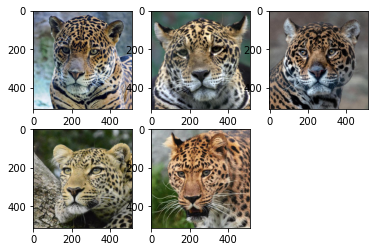

In [97]:
##########Test the model 
'''
Testing the prediction for the image as per the requirement  - n similar images to be returned  / displayed

'''
def plotting_images(list_images )  :
  '''
  Plotting the similar images from the list_images
  '''
  m = 0 
  n = 0 
  ##creating the subplot
  if len(list_images) % 2 == 0 :
     m = len(list_images) / 2
     n = len(list_images) / m 
  else:
    m = len(list_images) / 2
    n = (len(list_images) / m) + 1 

  print(len(list_images))
  print(m , n , list_images[0].shape)
  count_image = 0
  for indm in range(1,len(list_images) + 1 ) :
  
    print(int(str(int(m))+str(int(n))+str(int(indm))))
    plt.subplot(int(str(int(m))+str(int(n))+str(int(indm))))
    plt.imshow(list_images[count_image][:,:,:])
    count_image += 1 
  plt.show()

    
def read_image (indpath) :
  '''read the input image '''
  im = Image.open(indpath)
  #reading the image and convert  to the RGB
  rgb_im = im.convert('RGB')
  rgb_im = np.array(rgb_im)
  return rgb_im
  
def predict_output(img ) :
  '''model prediction for the image '''
  rgb_im = img / 255
  indimg = np.expand_dims(rgb_im, axis=0)  
  print(indimg.shape)
  res = model.predict(indimg) 
  res= list(res[0])
  print(res , max(res))
  print(max(res) , classes_list[res.index(max(res))])
  return max(res) , classes_list[res.index(max(res))]
def similar_images(proba, df_sim, class_name, n_images, database_input) :
  '''Returns the n similar images''' 
  print(class_name)
  row_numbers = df_sim.index[df_sim['res'] == class_name].tolist()

  print(row_numbers, type(row_numbers))
  input_paths_images = [os.path.join(database_input, str(df_sim.iloc[indices]['img'])+ '.jpg' ) for indices in row_numbers  ] 
  list_images = [read_image(indpath) for indpath in input_paths_images]
  return list_images[:n_images]


   
print('The number of similar images to be displayed')
database_input = path 
indpath = r'/content/content/My Drive/Avanti/dataset_unzip/dataset/1.jpg'
database_input = r'/content/content/My Drive/Avanti/dataset_unzip/dataset'
image_count = int(input())
if image_count > 0 :
  df_sim = pd.read_csv(csv_path)
  img =  read_image(indpath)
  prediction_proba, class_name = predict_output(img)
  list_images = similar_images(prediction_proba , df_sim, class_name, image_count,database_input)
  print('plotting the images')
  plotting_images(list_images)

else :
  print('count should be > 0 ')